In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

from Logit import logFit, logPredict

In [2]:
df = pd.read_csv("framingham.csv")
df.dropna(axis=0, inplace=True)
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

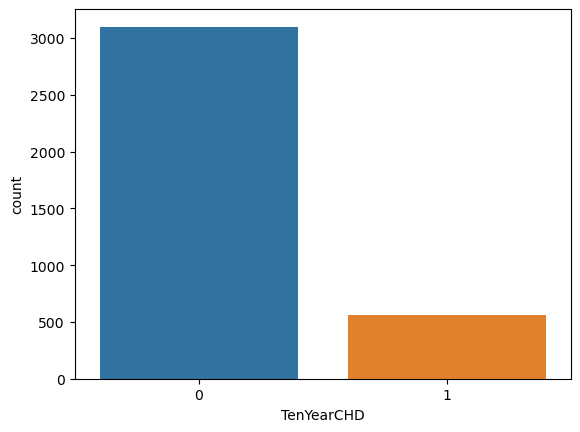

In [3]:
sns.countplot(x="TenYearCHD", data=df)
plt.show()

In [4]:
#check correlation matrix
df.corr()["TenYearCHD"]

male               0.091745
age                0.233810
education         -0.063068
currentSmoker      0.019176
cigsPerDay         0.052159
BPMeds             0.089116
prevalentStroke    0.048351
prevalentHyp       0.181556
diabetes           0.093397
totChol            0.091127
sysBP              0.222885
diaBP              0.150342
BMI                0.081931
heartRate          0.020523
glucose            0.121942
TenYearCHD         1.000000
Name: TenYearCHD, dtype: float64

**Observation:**
- The correlation coefficients between the each factor and TenYearCHD is very low

### Exploring Dependency between the TenYearCHD and each Factor using Chi-Squared Test

- Null Hypothesis:
    - Variables been compared are indenpendent of one another (> 5%)
- Alternative Hypotheses
    - Variables been compared are not independent of one another. (<5%)

In [5]:
x = df.iloc[:, :15]
y = df.iloc[:, -1]
x.shape, y.shape

((3656, 15), (3656,))

In [13]:
#check for dependency
chi_square, pvalues = chi2(x,y)

dependence_df = pd.DataFrame([chi_square, pvalues], 
                             columns =  x.columns, 
                             index = ["chi_square", "pvalues"]).transpose()
dependence_df

,chi_square,pvalues
male,17.120430,3.508289e-05
age,295.507761,3.136918e-66
education,7.679797,5.584246e-03
currentSmoker,0.686913,4.072163e-01
cigsPerDay,156.567318,6.363520e-36
BPMeds,28.153003,1.120936e-07
prevalentStroke,8.497823,3.555717e-03
prevalentHyp,82.967184,8.342694e-20
diabetes,31.027987,2.543345e-08
totChol,249.153078,3.972625e-56


### Feature Selection using Chi-Squared Test
- Factors with p_values less than 5% indicate that there is some dependency on the outcome variable TenYearCHD. As a result, tell us something about the outcome. 


In [20]:
x_var = [dependence_df.index[i] for i in range(len(dependence_df)) if dependence_df["pvalues"][i] < 0.05]
new_x = df[x_var]

#scale values of x to be between 0 and 1
scaler = MinMaxScaler()
df_x = scaler.fit_transform(new_x)

#train_test_split
x_train, x_test, y_train, y_test = tts(df_x, y, test_size=0.3, random_state=42)

#predict TenYearCHD using LogisticRegression
model_ = LogisticRegression().fit(x_train, y_train)
y_hat = model_.predict(x_test)

#check accuracy using 
print("Percentage Accuracy\t" + str(f1_score(y_test, y_hat)*100))

Percentage Accuracy	13.471502590673579


According to Framingham Risk Score Study, Probability values for risk of TenYearCHD greater than or equal to 20% indicate high risk of TenYearCHD

Reference: https://en.wikipedia.org/wiki/Framingham_Risk_Score

**Observation:**

- Prediction Accuracy is Low according f1_score

### Exploring the manually written Logistic Regression Algorithm

- Aim:
    - Prioritize optimizing logistic regression equation estimates over latency.

In [61]:
def data_transform(x):
    model_x = np.c_[np.ones(shape=(x.shape[0],1)),x]
    return model_x

def beta_initialize(x):
    beta = np.zeros(shape=(data_transform(x).shape[1],1))
    return beta

beta, Xtrain, Xtest = beta_initialize(new_x), data_transform(x_train), data_transform(x_test)

# fit data
beta, loss = logFit(Xtrain, y_train.values.reshape(-1,1), beta)

# predicting output variable (TenYearCHD)
y_hat_logit = logPredict(Xtest, beta, 0.5)

#check accuracy using 
print("Percentage Accuracy\t" + str(f1_score(y_test, y_hat_logit)*100))

Percentage Accuracy	15.075376884422113


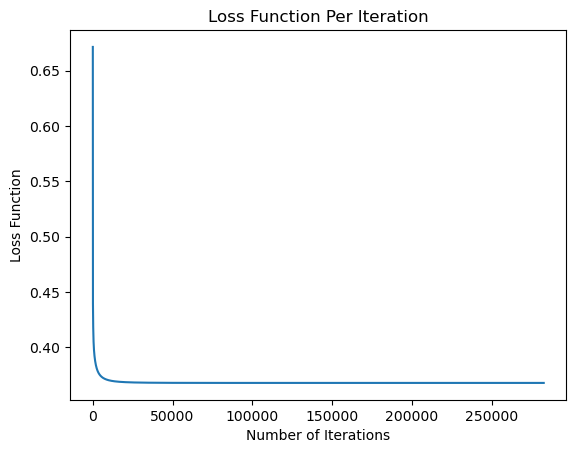

In [62]:
# plotting loss function
plt.plot(loss)
plt.title('Loss Function Per Iteration')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss Function')
plt.show()

**Observation**
- Result from manually built logit model performs slightly better than LogisticRegression algorithm from sklearn.
- According to the loss function graph, global minimum was obtained between 0 and 50,000 iterations, therefore informing our hyperparameter tuning strategy

### Approximation Threshold Adjustment
- From research, the Famingham Risk Score states that individuals with probability estimation greater than 20% have a high risk of Coronary Heart Disease Adjust Approximation Threshold to 20%

    - Reference: https://en.wikipedia.org/wiki/Framingham_Risk_Score

In [107]:
#change classification threshold to 0.2
model_ = LogisticRegression(max_iter = 50000).fit(x_train, y_train)
prob = model_.predict_proba(x_test)[:, 1]
Y_hat = [1 if prob[i] >= 0.2 else 0 for i in range(len(prob))]
print("Percentage Accuracy\t"+ str(f1_score(y_test, Y_hat)*100))

Percentage Accuracy	38.443935926773456


### Performance Evaluation

In [69]:
confusion_matrix_sklearn = confusion_matrix(y_test, y_hat)
print(f'Initial Model (Sklearn) = \n{confusion_matrix_sklearn}\n')

confusion_matrix_logit = confusion_matrix(y_test, y_hat_logit)
print(f'Initial Model (Logit) = \n{confusion_matrix_logit}\n')

confusion_matrix_tuned = confusion_matrix(y_test, Y_hat)
print(f'f1_score at threshold = 0.2: \n{confusion_matrix_tuned}')

Initial Model (Sklearn) = 
[[917   6]
 [161  13]]

Initial Model (Logit) = 
[[913  10]
 [159  15]]

f1_score at threshold = 0.2: 
[[744 179]
 [ 90  84]]


### Examining Bias in the Dataset

Considerations:
- Primary factor = Smoking
- Counfounding variables = age, gender

In [71]:
group_by_currentSmoker = df.groupby("currentSmoker").agg({"male":"count","age":"mean", "cigsPerDay":"mean", "BPMeds": "sum",
                                                              "prevalentStroke":"sum", "prevalentHyp":"sum", "diabetes":"sum",
                                                              "totChol":"mean", "BMI":"mean", "heartRate":"mean", "glucose":"mean",
                                                              "TenYearCHD":"sum"})
group_by_currentSmoker.transpose()

currentSmoker,0,1
male,1868.000000,1788.000000
age,51.323340,47.712528
cigsPerDay,0.000000,18.447987
BPMeds,73.000000,38.000000
prevalentStroke,16.000000,5.000000
prevalentHyp,673.000000,466.000000
diabetes,63.000000,36.000000
totChol,239.078158,234.569351
BMI,26.418865,25.121107
heartRate,75.139186,76.348434


In [72]:
#group by gender
group_by_gender = df.groupby(["currentSmoker", "male"]).agg({"age":"mean", "cigsPerDay":"mean", "BPMeds": "sum",
                                                              "prevalentStroke":"sum", "prevalentHyp":"sum", "diabetes":"sum",
                                                              "totChol":"mean", "BMI":"mean", "heartRate":"mean", "glucose":"mean",
                                                              "TenYearCHD":"sum"})
group_by_gender.transpose()

currentSmoker             0                       1            
male                      0           1           0           1
age               51.594947   50.803432   46.929368   48.356779
cigsPerDay         0.000000    0.000000   13.855019   22.226300
BPMeds            54.000000   19.000000   24.000000   14.000000
prevalentStroke   10.000000    6.000000    2.000000    3.000000
prevalentHyp     457.000000  216.000000  176.000000  290.000000
diabetes          34.000000   29.000000   17.000000   19.000000
totChol          243.171964  231.241810  234.265180  234.819572
BMI               26.213456   26.812059   24.464758   25.661040
heartRate         76.665852   72.216849   77.407683   75.477064
glucose           82.647107   83.978159   80.489467   80.604485
TenYearCHD       162.000000  110.000000   88.000000  197.000000

Age Distribution

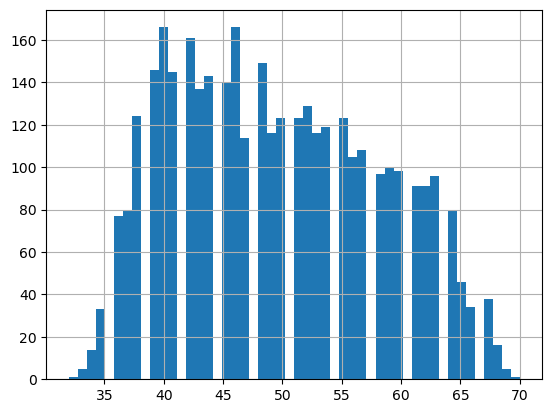

In [73]:
df["age"].hist(bins=50)
plt.show()

In [74]:
age_bins = [30, 39, 49, 59, 69, 79]
age_labels = ["30-39", "40-49", "50-59", "60-69", "70-79"]
df["age_grp"] = pd.cut(df["age"], bins=age_bins, labels=age_labels)
cols = [df.columns[-1]]
for i in range(len(df.columns[:16])):
  cols.append(df.columns[i])

df = df[cols]
df.sample(1)

,age_grp,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
895,40-49,1,45,1.0,1,20.0,0.0,0,0,0,255.0,130.0,82.5,28.56,82.0,94.0,0


In [75]:
group_by_ageClass = df.groupby("age_grp").agg({"TenYearCHD": "sum"})
group_by_ageClass

,TenYearCHD
age_grp,
30-39,21
40-49,138
50-59,230
60-69,168
70-79,0


In [76]:
group_by_ageSmoker = df.groupby("age_grp").agg({"currentSmoker": "sum"})
group_by_ageSmoker

,currentSmoker
age_grp,
30-39,278
40-49,841
50-59,484
60-69,185
70-79,0


In [77]:
#Grouping the Data
a = len(df[(df["currentSmoker"]==1)&(df["TenYearCHD"]==1)])
b = len(df[(df["currentSmoker"]==1) & (df["TenYearCHD"]==0)])
c = len(df[(df["currentSmoker"]==0) & (df["TenYearCHD"] == 1)])
d = len(df[(df["currentSmoker"]==0) & (df["TenYearCHD"] == 0)])

tot_r1 = a+b
tot_r2 = c+d
tot_c1 = a+c
tot_c2 = b+d
tot_c3 = tot_r1 + tot_r2

unadjusted_analysis = pd.DataFrame([[a, b, tot_r1], [c, d, tot_r2], [tot_c1, tot_c2, tot_c3]], 
                              columns = ["TenYearCHD", "NoTenYearCHD", "total"], 
                              index = ["Smoker", "NonSmoker", "Total"])
unadjusted_analysis 

,TenYearCHD,NoTenYearCHD,total
Smoker,285,1503,1788
NonSmoker,272,1596,1868
Total,557,3099,3656


In [78]:
crude_RiskRatio = (unadjusted_analysis["TenYearCHD"]["Smoker"]/ unadjusted_analysis["total"]["Smoker"]) / (unadjusted_analysis["TenYearCHD"]["NonSmoker"]/ unadjusted_analysis["total"]["NonSmoker"])
crude_RiskRatio

1.0946752862218714

* Stratifying the data by age

In [80]:
heart_young = df[df["age"] < 50]
heart_old = df[df["age"] >= 50]

a_y = len(heart_young[(heart_young["currentSmoker"]==1)&(heart_young["TenYearCHD"]==1)])
b_y = len(heart_young[(heart_young["currentSmoker"]==1) & (heart_young["TenYearCHD"]==0)])
c_y = len(heart_young[(heart_young["currentSmoker"]==0) & (heart_young["TenYearCHD"] == 1)])
d_y = len(heart_young[(heart_young["currentSmoker"]==0) & (heart_young["TenYearCHD"] == 0)])

tot_r1_y = a_y + b_y
tot_r2_y = c_y + d_y
tot_c1_y = a_y + c_y
tot_c2_y = b_y + d_y
tot_c3_y = tot_r1_y + tot_r2_y

strat_young = pd.DataFrame([[a_y, b_y, tot_r1_y], [c_y, d_y, tot_r2_y], [tot_c1_y, tot_c2_y, tot_c3_y]], 
                              columns = ["TenYearCHD_Young", "NoTenYearCHD_Young", "total_Young"], 
                              index = ["Smoker", "NonSmoker", "Total"])
strat_young

,TenYearCHD_Young,NoTenYearCHD_Young,total_Young
Smoker,113,1006,1119
NonSmoker,46,752,798
Total,159,1758,1917


In [81]:
RiskRatio_young = (strat_young["TenYearCHD_Young"]["Smoker"]/ strat_young["total_Young"]["Smoker"]) / (strat_young["TenYearCHD_Young"]["NonSmoker"]/ strat_young["total_Young"]["NonSmoker"])
RiskRatio_young

1.7518358783074952

In [83]:
a_o = len(heart_old[(heart_old["currentSmoker"]==1)&(heart_old["TenYearCHD"]==1)])
b_o = len(heart_old[(heart_old["currentSmoker"]==1) & (heart_old["TenYearCHD"]==0)])
c_o = len(heart_old[(heart_old["currentSmoker"]==0) & (heart_old["TenYearCHD"] == 1)])
d_o = len(heart_old[(heart_old["currentSmoker"]==0) & (heart_old["TenYearCHD"] == 0)])

tot_r1_o = a_o + b_o
tot_r2_o = c_o + d_o
tot_c1_o = a_o + c_o
tot_c2_o = b_o + d_o
tot_c3_o = tot_r1_o + tot_r2_o

strat_old = pd.DataFrame([[a_o, b_o, tot_r1_o], [c_o, d_o, tot_r2_o], [tot_c1_o, tot_c2_o, tot_c3_o]], 
                              columns = ["TenYearCHD_Old", "NoTenYearCHD_Old", "total_Old"], 
                              index = ["Smoker", "NonSmoker", "Total"])
strat_old

,TenYearCHD_Old,NoTenYearCHD_Old,total_Old
Smoker,172,497,669
NonSmoker,226,844,1070
Total,398,1341,1739


In [84]:
RiskRatio_old = (strat_old["TenYearCHD_Old"]["Smoker"]/ strat_old["total_Old"]["Smoker"]) / (strat_old["TenYearCHD_Old"]["NonSmoker"]/ strat_old["total_Old"]["NonSmoker"])
RiskRatio_old

1.2172440705318992

In [87]:
#Adjusted Risk Ratio
RRnum1 = (strat_young["TenYearCHD_Young"]["Smoker"] *
          (strat_young["TenYearCHD_Young"]["NonSmoker"]+ 
           strat_young["NoTenYearCHD_Young"]["NonSmoker"]))/(strat_young["total_Young"]["Total"])

RRnum2 = (strat_old["TenYearCHD_Old"]["Smoker"] *
          (strat_old["TenYearCHD_Old"]["NonSmoker"]+ 
           strat_old["NoTenYearCHD_Old"]["NonSmoker"]))/(strat_old["total_Old"]["Total"])

RRdenom1 = (strat_young["TenYearCHD_Young"]["NonSmoker"] *
            (strat_young["TenYearCHD_Young"]["Smoker"] + strat_young["NoTenYearCHD_Young"]["Smoker"]))/(strat_young["total_Young"]["Total"])

RRdenom2 = (strat_old["TenYearCHD_Old"]["NonSmoker"] *
            (strat_old["TenYearCHD_Old"]["Smoker"] + strat_old["NoTenYearCHD_Old"]["Smoker"]))/(strat_old["total_Old"]["Total"])

RR_adjusted = (RRnum1+RRnum2)/(RRdenom1+RRdenom2)
RR_adjusted

1.3433882484251098

In [86]:
mag_of_effect = ((crude_RiskRatio - RR_adjusted)/RR_adjusted)*100
mag_of_effect

-18.513855729705195

Causes of Cornary Heart Disease:
1. Smoking and Secondhand Smoke Exposure
2. High blood pressure
3. High low-density lipoprotein (LDL) cholesterol 
4. Diabetes
4. Obesity, unhealthy diet, and Physical inactivity

reference: https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm

Table Visualization:

Group exposures by confounder variables

In [88]:
#Smoking Class
smoking = df.groupby(["male", "age_grp","currentSmoker"]).agg({"TenYearCHD":"sum"}).transpose()
smoking

male              0                                               1           \
age_grp       30-39    40-49     50-59     60-69     70-79    30-39    40-49   
currentSmoker     0  1     0   1     0   1     0   1     0  1     0  1     0   
TenYearCHD        0  7    23  34    65  35    74  12     0  0     5  9    18   

male                                            
age_grp           50-59     60-69     70-79     
currentSmoker   1     0   1     0   1     0  1  
TenYearCHD     63    50  80    37  45     0  0

In [89]:
#Diabetes Class
diabetes = df.groupby(["male", "age_grp","diabetes"]).agg({"TenYearCHD":"sum"}).transpose()
diabetes

male           0                                            1              \
age_grp    30-39    40-49    50-59    60-69    70-79    30-39    40-49      
diabetes       0  1     0  1     0  1     0  1     0  1     0  1     0  1   
TenYearCHD     7  0    53  4    92  8    83  3     0  0    14  0    79  2   

male                                    
age_grp    50-59     60-69    70-79     
diabetes       0   1     0  1     0  1  
TenYearCHD   120  10    74  8     0  0

In [90]:
#Group into Obese(1) and Non-Obese(0)
bmi_class = [1 if i >= 30 else 0 for i in range(len(df["BMI"]))] #classification for obese obtained from CDC website
df["BMI"] = bmi_class
bmi = df.groupby(["male","age_grp","BMI"]).agg({"TenYearCHD": "sum"}).transpose()
bmi

male           0                                               1            \
age_grp    30-39    40-49     50-59     60-69     70-79    30-39     40-49   
BMI            0  1     0   1     0   1     0   1     0  1     0   1     0   
TenYearCHD     1  6     1  56     1  99     3  83     0  0     0  14     1   

male                                          
age_grp        50-59      60-69     70-79     
BMI          1     0    1     0   1     0  1  
TenYearCHD  80     0  130     0  82     0  0

In [91]:
#Blood Pressure Class
highBp = df.groupby(["male","age_grp","prevalentHyp"]).agg({"TenYearCHD": "sum"}).transpose()
highBp

male             0                                               1           \
age_grp      30-39    40-49     50-59     60-69     70-79    30-39    40-49   
prevalentHyp     0  1     0   1     0   1     0   1     0  1     0  1     0   
TenYearCHD       5  2    42  15    39  61    21  65     0  0    11  3    48   

male                                           
age_grp          50-59     60-69     70-79     
prevalentHyp   1     0   1     0   1     0  1  
TenYearCHD    33    69  61    38  44     0  0

Store Data Per Age Group and Stratify Each Group By Gender

In [92]:
for i in range(3,8):
  age_data = f"data_{i}0_{i}9" 
  exec(f'{age_data} = df[df["age_grp"] == f"{i}0-{i}9"]')

  male_data = f"male_{i}0_{i}9"
  exec(f'{male_data} = {age_data}[{age_data}["male"]==1]')

  female_data = f"female_{i}0_{i}9"
  exec(f'{female_data} = {age_data}[{age_data}["male"]==0]')

In [93]:
#check
male_30_39.sample(2)

,age_grp,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3567,30-39,1,37,2.0,0,0.0,0.0,0,0,0,212.0,114.5,77.0,1,87.0,68.0,0
616,30-39,1,39,2.0,0,0.0,0.0,0,0,0,203.0,117.5,77.5,1,88.0,60.0,0


create functions for calculating adjusted risk ratio and probability values

In [94]:
##exposure is a string value
def structure(data_frame, exposure, outcome):
  a = len(data_frame[(data_frame[exposure]==1)&(data_frame[outcome]==1)])
  b = len(data_frame[(data_frame[exposure]==1)&(data_frame[outcome]==0)])
  c = len(data_frame[(data_frame[exposure]==0)&(data_frame[outcome]==1)])
  d = len(data_frame[(data_frame[exposure]==0)&(data_frame[outcome]==0)])
  tot_r1 = a+b
  tot_r2 = c+d
  tot_c1 = a+c
  tot_c2 = b+d
  tot_c3 = tot_r1 + tot_r2
  mdl = pd.DataFrame([[a, b, tot_r1], [c, d, tot_r2], [tot_c1, tot_c2, tot_c3]], 
                              columns = [outcome, "no_"+outcome, "total"], 
                              index = [exposure, "no_"+exposure, "Total"])
  return mdl, exposure, outcome

##calculate Adjusted R
def adj_r(data_frame, exposure, outcome):
  model, exposure, outcome = structure(data_frame, exposure, outcome)
  no_outcome = "no_"+ outcome
  no_exposure = "no_"+ exposure
  numerator = (model[outcome][exposure] * (model[outcome][no_exposure] + model[no_outcome][no_exposure]))/(model["total"]["Total"])
  denominator = (model[outcome][no_exposure] * (model[outcome][exposure] + model[no_outcome][exposure]))/(model["total"]["Total"])
  return numerator, denominator

def getProba(data_frame, exposure, outcome):
  model, exposure, outcome = structure(data_frame, exposure, outcome)
  no_outcome = "no_"+outcome
  no_exposure = "no_"+exposure
  proba_outcome_given_unexposed = model[outcome][no_exposure]/model["total"][no_exposure]
  return proba_outcome_given_unexposed

In [95]:
#check
structure_test = structure(data_30_39, "currentSmoker", "TenYearCHD")[0]
structure_test

,TenYearCHD,no_TenYearCHD,total
currentSmoker,16,262,278
no_currentSmoker,5,197,202
Total,21,459,480


Further Data Processing

In [96]:
#create new df for further data processing
processed = df[["age_grp", "age", "currentSmoker", "prevalentHyp", "diabetes", "BMI", "TenYearCHD"]]

In [97]:
processed[processed["age"]>=70]

,age_grp,age,currentSmoker,prevalentHyp,diabetes,BMI,TenYearCHD
3137,70-79,70,0,1,0,1,0


Since there is just one person in the age group of 70-79, let us ignore that for now

In [ ]:
processed.drop(3137, axis=0, inplace=True)
processed.reset_index(inplace=True)

In [101]:
processed.sample(2)

,index,age_grp,age,currentSmoker,prevalentHyp,diabetes,BMI,TenYearCHD
1863,2180,60-69,63,0,0,1,1,0
2206,2562,40-49,40,0,1,0,1,0


Change values of Exposure Variables in Processed Table to Probability values such that probability of exposed individuals in each age group is a multiple of the probability values of unexposed individuals given that confounding has been taken into consideration

In [ ]:
#calculating Risk Ratios, Adjusted_Risk Ratios and Probabilities

exposures = ["currentSmoker", "prevalentHyp", "diabetes", "BMI"]

for i in range(len(exposures)):
  #Age 30-39
  male_RRnum_30_39, male_RRdenom_30_39 = adj_r(male_30_39, exposures[i], "TenYearCHD")
  female_RRnum_30_39, female_RRdenom_30_39 = adj_r(female_30_39, exposures[i], "TenYearCHD")
  adjusted_R_30_39 = (male_RRnum_30_39 + female_RRnum_30_39)/(male_RRdenom_30_39 + female_RRdenom_30_39)

  #Age 40-49
  male_RRnum_40_49, male_RRdenom_40_49 = adj_r(male_40_49, exposures[i], "TenYearCHD")
  female_RRnum_40_49, female_RRdenom_40_49 = adj_r(female_40_49, exposures[i], "TenYearCHD")
  adjusted_R_40_49 = (male_RRnum_40_49 + female_RRnum_40_49)/(male_RRdenom_40_49 + female_RRdenom_40_49)

  #Age 50-59
  male_RRnum_50_59, male_RRdenom_50_59 = adj_r(male_50_59, exposures[i], "TenYearCHD")
  female_RRnum_50_59, female_RRdenom_50_59 = adj_r(female_50_59, exposures[i], "TenYearCHD")
  adjusted_R_50_59 = (male_RRnum_50_59 + female_RRnum_50_59)/(male_RRdenom_50_59 + female_RRdenom_50_59)

  #Age 60-69
  male_RRnum_60_69, male_RRdenom_60_69 = adj_r(male_60_69, exposures[i], "TenYearCHD")
  female_RRnum_60_69, female_RRdenom_60_69 = adj_r(female_60_69, exposures[i], "TenYearCHD")
  adjusted_R_60_69 = (male_RRnum_60_69 + female_RRnum_60_69)/(male_RRdenom_60_69 + female_RRdenom_60_69)

  for j in range(len(processed)):
    #Age 30-39
    if processed["age_grp"][j] == "30-39" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_30_39, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "30-39" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_30_39, exposures[i], "TenYearCHD")* adjusted_R_30_39
  
    #Age 40-49
    elif processed["age_grp"][j] == "40-49" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_40_49, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "40-49" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_40_49, exposures[i], "TenYearCHD")* adjusted_R_40_49
  
    #Age 50-59
    elif processed["age_grp"][j] == "50-59" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_50_59, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "50-59" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_50_59, exposures[i], "TenYearCHD")* adjusted_R_50_59

    #Age 60-69
    elif processed["age_grp"][j] == "60-69" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_60_69, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "60-69" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_60_69, exposures[i], "TenYearCHD")* adjusted_R_60_69

New Prediction Using Processed Table

In [106]:
#x and y variables for processed table
x_pr = processed[["age","currentSmoker", "prevalentHyp", "diabetes", "BMI"]]
y_pr = processed["TenYearCHD"]

#train_test_split for processed table
x_train_pr, x_test_pr, y_train_pr, y_test_pr = tts(x_pr, y_pr, test_size=0.4, random_state=4)

#predict TenYearCHD using LogisticRegression
model_pr = LogisticRegression().fit(x_train_pr, y_train_pr)

#classification threshold = 0.2
prob_pr = model_pr.predict_proba(x_test_pr)[:, 1]
y_hat_pr = [1 if prob_pr[i] >= 0.2 else 0 for i in range(len(prob_pr))]
print("Percentage Accuracy\t"+ str(f1_score(y_test_pr, y_hat_pr)*100))

Percentage Accuracy	37.47747747747748
